In [2]:
# %load  /home/mt/code/templates/firstcell.py
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib agg

In [241]:
# %load  /home/mt/code/templates/secondcell.py
import numpy as np
import os,pickle,sys,fnmatch,shutil
from os.path import join

import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams.update({'figure.max_open_warning': 0})


import xarray as xr
import xml.etree.ElementTree as ET

# sys.path += [here+'../code']

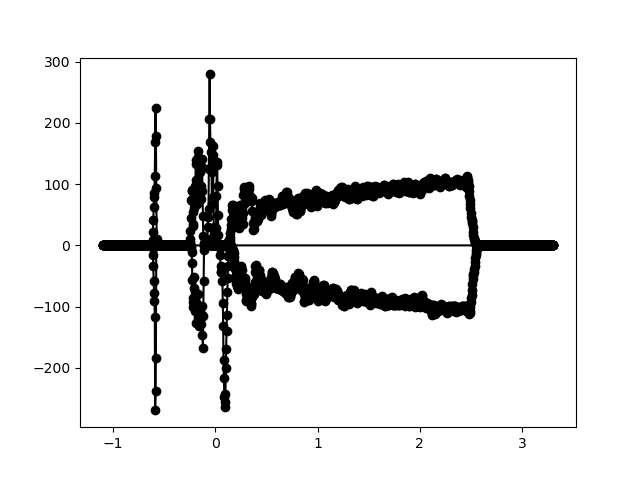

In [245]:

TDOS = np.loadtxt('fm/TDOS.OUT')
plt.figure()
plt.plot(TDOS[:,0],TDOS[:,1],'-ok')


In [246]:
tree = ET.parse('fm/dos.xml')
root = tree.getroot()

for child in root:
    print(child.tag, child.attrib)
    
for child in root[4]:
    print(child.tag, child.attrib)

title {}
axis {'label': 'Energy', 'unit': 'Hartree'}
axis {'label': 'DOS', 'unit': 'states/Hartree/unit cell'}
totaldos {}
partialdos {'type': 'partial', 'speciessym': '', 'speciesrn': '1', 'atom': '1'}
partialdos {'type': 'partial', 'speciessym': '', 'speciesrn': '1', 'atom': '2'}
partialdos {'type': 'partial', 'speciessym': '', 'speciesrn': '2', 'atom': '1'}
partialdos {'type': 'partial', 'speciessym': '', 'speciesrn': '2', 'atom': '2'}
partialdos {'type': 'partial', 'speciessym': '', 'speciesrn': '2', 'atom': '3'}
partialdos {'type': 'partial', 'speciessym': '', 'speciesrn': '2', 'atom': '4'}
limrep {}
interstitialdos {}
diagram {'nspin': '1', 'l': '0', 'm': '0'}
diagram {'nspin': '1', 'l': '1', 'm': '-1'}
diagram {'nspin': '1', 'l': '1', 'm': '0'}
diagram {'nspin': '1', 'l': '1', 'm': '1'}
diagram {'nspin': '1', 'l': '2', 'm': '-2'}
diagram {'nspin': '1', 'l': '2', 'm': '-1'}
diagram {'nspin': '1', 'l': '2', 'm': '0'}
diagram {'nspin': '1', 'l': '2', 'm': '1'}
diagram {'nspin': '1'

In [273]:

 
E = 27.211386245*np.array([float(child.attrib['e']) for child in root[3][0]])

###check spin polarization
for child in root[4]:
    if child.attrib['nspin'] == '2':
        spin_polarized = True
    else:
        spin_polarized = False

coor_atoms = range(6) 
if spin_polarized:
    coor_spin  = range(2) # up,down
    tdos = np.zeros(( len(coor_spin),len(E) ))
    tdos[0,:] = np.array([float(child.attrib['dos']) for child in root[3][0]])
    tdos[1,:] = np.array([float(child.attrib['dos']) for child in root[3][1]])
    intdos = np.zeros(( len(coor_spin),len(E) ))
    intdos[0,:] = np.array([float(child.attrib['dos']) for child in root[-1][0]])
    intdos[1,:] = np.array([float(child.attrib['dos']) for child in root[-1][1]])
else:
    coor_spin  = range(1) # up only
    tdos[0,:] = np.array([float(child.attrib['dos']) for child in root[3][0]])
    intdos = np.zeros(( len(coor_spin),len(E) ))
    intdos[0,:] = np.array([float(child.attrib['dos']) for child in root[-1][0]])    
    
    
coor_l     = [0,1,2,3,4] # s,p.d,f,g
coor_m     = [-4,-3,-2,-1,0,1,2,3,4] # 
pdos_all = np.zeros(( len(coor_atoms),len(coor_spin),len(coor_l),len(coor_m), len(E) ))
for a in coor_atoms:
    for child in root[a+4]:
        dos = np.array([float(dd.attrib['dos']) for dd in child])
        pdos_all[a,int(child.attrib['nspin'])-1,int(child.attrib['l']),int(child.attrib['m'])+4,:] = dos
        
 
pdos = np.zeros(( len(coor_atoms),len(coor_spin),len(coor_l),len(E) ))
for a in coor_atoms:
    for s in coor_spin:
        for l in coor_l:
            if l == 0:  
                pdos[a,s,l] = pdos_all[a,s,l,4,:] 
            elif l == 1:  
                pdos[a,s,l] = np.sum(pdos_all[a,s,l,3:5,:],axis=0)
            elif l == 2:  
                pdos[a,s,l] = np.sum(pdos_all[a,s,l,2:6,:],axis=0)
            elif l == 3:  
                pdos[a,s,l] = np.sum(pdos_all[a,s,l,1:7,:],axis=0)
            elif l == 4:  
                pdos[a,s,l] = np.sum(pdos_all[a,s,l,0:8,:],axis=0)   
                


ds = xr.Dataset()             
ds['tdos'] = xr.DataArray(data=tdos,
                    coords=[coor_spin,E],
                    dims=['spin', 'energy']
                    )

ds['interstitialdos']  = xr.DataArray(data=intdos,
                    coords=[coor_spin,E],
                    dims=['spin', 'energy']
                    )

ds['pdos']  = xr.DataArray(data=pdos,
                    coords=[coor_atoms,coor_spin,coor_l,E],
                    dims=['atoms', 'spin', 'l', 'energy']
                    )

                                    
ds

<xarray.Dataset>
Dimensions:          (spin: 2, energy: 1201, atoms: 6, l: 5)
Coordinates:
  * spin             (spin) int64 0 1
  * energy           (energy) float64 -30.0 -29.9 -29.8 -29.7 ... 89.8 89.9 90.0
  * atoms            (atoms) int64 0 1 2 3 4 5
  * l                (l) int64 0 1 2 3 4
Data variables:
    tdos             (spin, energy) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    interstitialdos  (spin, energy) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pdos             (atoms, spin, l, energy) float64 0.0 0.0 0.0 ... 0.0 0.0

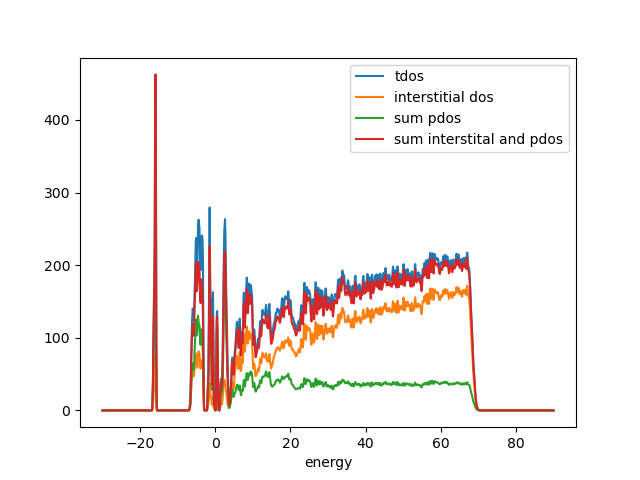

In [277]:
plt.figure()

ds.tdos.sum(dim=('spin')).plot(label='tdos')
ds.interstitialdos.sum(dim=('spin')).plot(label='interstitial dos')
ds.pdos.sum(dim=('atoms','spin','l')).plot(label='sum pdos')
(ds.pdos.sum(dim=('atoms','spin','l'))+ds.interstitialdos.sum(dim=('spin'))).plot(label='sum interstital and pdos')

plt.legend()

In [293]:
def read_pdos(xml_path,plot=False):
    """
    Reads dos.xml file from EXCITING calculation as an xarray dataset.

    USAGE:
    ds = read_pdos('dos.xml')
    plt.figure()
    ds.tdos.sum(dim=('spin')).plot(label='tdos')
    ds.interstitialdos.sum(dim=('spin')).plot(label='interstitial dos')
    ds.pdos.sum(dim=('atoms','spin','l')).plot(label='sum pdos')
    (ds.pdos.sum(dim=('atoms','spin','l'))+ds.interstitialdos.sum(dim=('spin'))).plot(label='sum interstital and pdos')
    plt.legend()

    """

    import xarray as xr
    import xml.etree.ElementTree as ET

    tree = ET.parse(xml_path)
    root = tree.getroot()

    E = 27.211386245*np.array([float(child.attrib['e']) for child in root[3][0]])

    ###check spin polarization
    for child in root[4]:
        if child.attrib['nspin'] == '2':
            spin_polarized = True
        else:
            spin_polarized = False

    coor_atoms = range(6)
    if spin_polarized:
        coor_spin  = range(2) # up,down
        tdos = np.zeros(( len(coor_spin),len(E) ))
        tdos[0,:] = np.array([float(child.attrib['dos']) for child in root[3][0]])
        tdos[1,:] = np.array([float(child.attrib['dos']) for child in root[3][1]])
        intdos = np.zeros(( len(coor_spin),len(E) ))
        intdos[0,:] = np.array([float(child.attrib['dos']) for child in root[-1][0]])
        intdos[1,:] = np.array([float(child.attrib['dos']) for child in root[-1][1]])
    else:
        coor_spin  = range(1) # up only
        tdos = np.zeros(( len(coor_spin),len(E) ))
        tdos[0,:] = np.array([float(child.attrib['dos']) for child in root[3][0]])
        intdos = np.zeros(( len(coor_spin),len(E) ))
        intdos[0,:] = np.array([float(child.attrib['dos']) for child in root[-1][0]])

    coor_l     = [0,1,2,3,4] # s,p.d,f,g
    coor_m     = [-4,-3,-2,-1,0,1,2,3,4] #
    pdos_all = np.zeros(( len(coor_atoms),len(coor_spin),len(coor_l),len(coor_m), len(E) ))
    for a in coor_atoms:
        for child in root[a+4]:
            dos = np.array([float(dd.attrib['dos']) for dd in child])
            pdos_all[a,int(child.attrib['nspin'])-1,int(child.attrib['l']),int(child.attrib['m'])+4,:] = dos

    pdos = np.zeros(( len(coor_atoms),len(coor_spin),len(coor_l),len(E) ))
    for a in coor_atoms:
        for s in coor_spin:
            for l in coor_l:
                if l == 0:
                    pdos[a,s,l] = pdos_all[a,s,l,4,:]
                elif l == 1:
                    pdos[a,s,l] = np.sum(pdos_all[a,s,l,3:5,:],axis=0)
                elif l == 2:
                    pdos[a,s,l] = np.sum(pdos_all[a,s,l,2:6,:],axis=0)
                elif l == 3:
                    pdos[a,s,l] = np.sum(pdos_all[a,s,l,1:7,:],axis=0)
                elif l == 4:
                    pdos[a,s,l] = np.sum(pdos_all[a,s,l,0:8,:],axis=0)


    ds = xr.Dataset()
    ds['tdos'] = xr.DataArray(data=tdos,
                        coords=[coor_spin,E],
                        dims=['spin', 'energy']
                        )

    ds['interstitialdos']  = xr.DataArray(data=intdos,
                        coords=[coor_spin,E],
                        dims=['spin', 'energy']
                        )

    ds['pdos']  = xr.DataArray(data=pdos,
                        coords=[coor_atoms,coor_spin,coor_l,E],
                        dims=['atoms', 'spin', 'l', 'energy']
                        )

    if plot:
        import matplotlib.pyplot as plt
        plt.figure()
        ds.tdos.sum(dim=('spin')).plot(label='tdos')
        ds.interstitialdos.sum(dim=('spin')).plot(label='interstitial dos')
        ds.pdos.sum(dim=('atoms','spin','l')).plot(label='sum of pdos')
        (ds.pdos.sum(dim=('atoms','spin','l'))+ds.interstitialdos.sum(dim=('spin'))).plot(label='sum of interstital and pdos')
        plt.title(xml_path)
        plt.legend()

    return ds

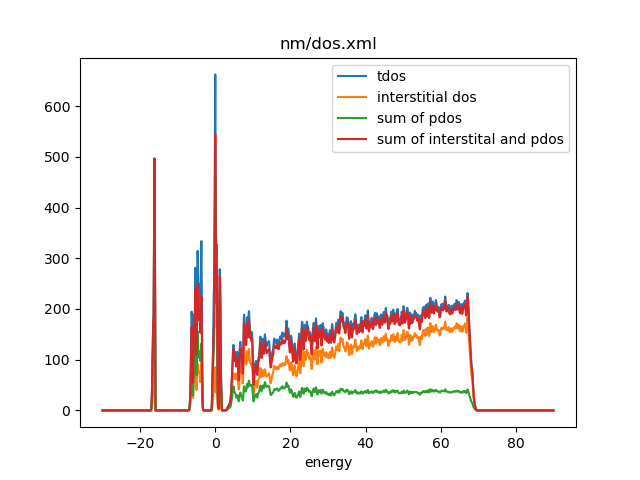

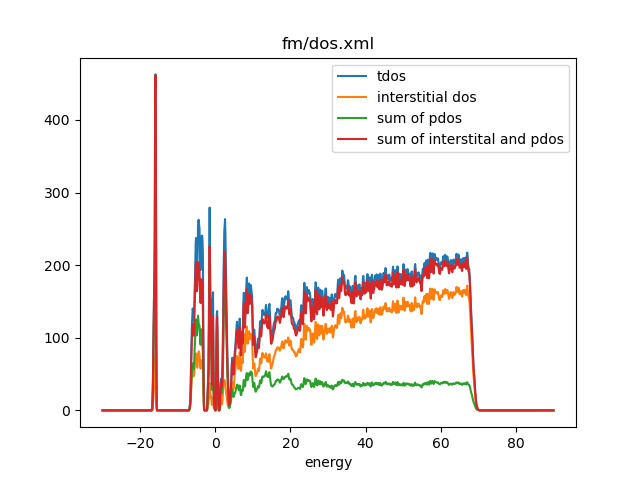

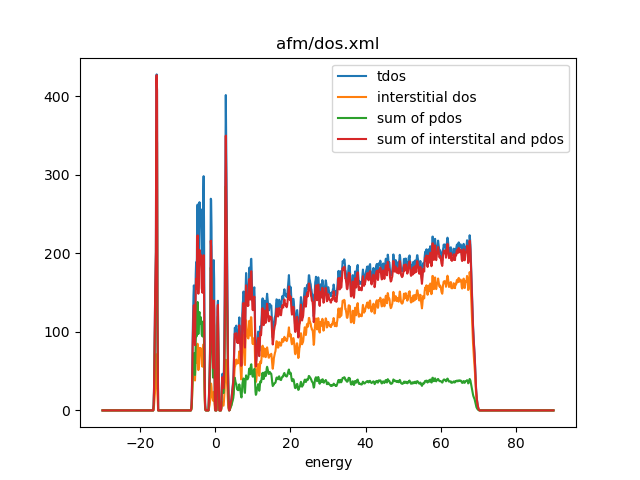

In [295]:
ds_nm = read_pdos('nm/dos.xml',plot=True)
ds_fm = read_pdos('fm/dos.xml',plot=True)
ds_afm = read_pdos('afm/dos.xml',plot=True)

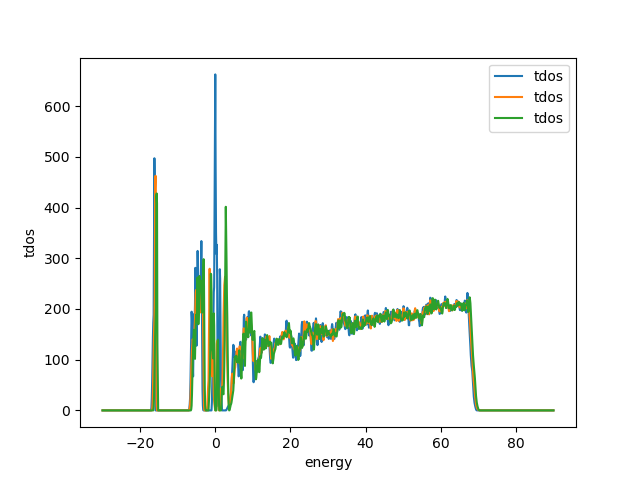

In [289]:
plt.figure()
ds_nm.tdos.sum(dim=('spin')).plot(label='tdos')
ds_fm.tdos.sum(dim=('spin')).plot(label='tdos')  
ds_afm.tdos.sum(dim=('spin')).plot(label='tdos') 
plt.legend()

In [5]:
from mEXCITING.readers import read_pdos

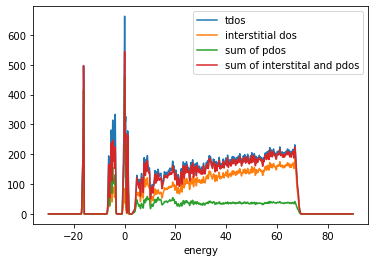

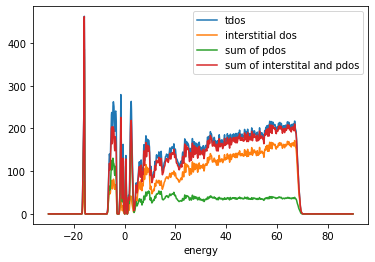

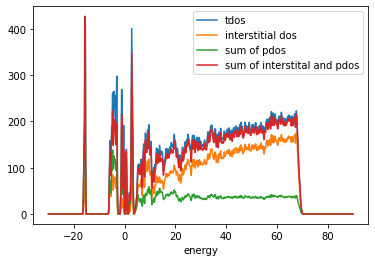

In [6]:
ds_nm = read_pdos('nm/dos.xml',plot=True)
ds_fm = read_pdos('fm/dos.xml',plot=True)
ds_afm = read_pdos('afm/dos.xml',plot=True)